# CQF Exam 2 - John Thompson

In [121]:
import numpy as np
import scipy.linalg as linalg
import time
import matplotlib.pyplot as plt

In [122]:
A = np.array([[0,3,-1,8],[-1,11,-1,3],[2,-1,10,-1],[10,-1,2,0]])
b = np.array([[15],[25],[-11],[6]])

## Q1: Write a program to test if the matrix A is strictly diagonally dominant.

#### Definition of a strictly diagonally dominant matrix

A n x n square matrix [A] is diagonally dominant if 

$ |A_{ii}| > \Sigma^n_{j=1}|A_{ij}| $ for i = 1,2,...,n and i $ \neq $ j 

that is, for each row, the absolute value of the diagonal elements is strictly greater than the sum of the absolute values of the remaining elements of that row.

In [151]:
def SDD(Matrix):
    D = np.diag(np.abs(Matrix)) # Find absolute value of diagonal coefficients 
    S = np.sum(np.abs(Matrix), axis=1) - D # Find absolute row sum without diagonal element
    num_rows, num_cols = Matrix.shape
    
    if np.all(D > S): 
        print('This matrix IS strictly diagonally dominant.')
    else:
        print('This matrix IS NOT strictly diagonally dominant.')

    print('\nFor strict diagonal dominance the sum of the absolute values of the diagonal row elements minus the sum of the absolute values of the non-diagonal elements should be > 0 for ALL rows.',
              '\n',
              '\nResults for each row shown below:')
    for i in range(0,num_rows):
            print('D - S for','Row',str(i),':', D[i]-S[i])
    return 

In [152]:
sdd_Check = SDD(A)
sdd_Check

This matrix IS NOT strictly diagonally dominant.

For strict diagonal dominance the sum of the absolute values of the diagonal row elements minus the sum of the absolute values of the non-diagonal elements should be > 0 for ALL rows. 
 
Results for each row shown below:
D - S for Row 0 : -12
D - S for Row 1 : 6
D - S for Row 2 : 6
D - S for Row 3 : -13


**-----------------------------------------------------------------------------------------------------------------------------------

**-----------------------------------------------------------------------------------------------------------------------------------

## Q2) LU Decomposition:
### Write a program to obtain a solution of (*) using both methods of Doolittle and Crout. Your program in each case should list L and U, followed by the solution for x.

In [125]:
def pivot_matrix(M):
    
    # Returns the pivoting matrix for M
    n_a = len(M)
    
    # Create an identity matrix, with floating point values 
    id_mat = [[float(i == j) for i in range(n_a)] for j in range(n_a)]
    
    # Rearrange the identity matrix such that the largest element of                                                                                                                                                                                   
    # each column of M is placed on the diagonal of M
    for j in range(n_a):
        row = max(range(j, n_a), key=lambda i: abs(M[i][j]))
        if j != row:
            #swap the rows
            id_mat[j], id_mat[row] = id_mat[row], id_mat[j]
            
    return id_mat

#### Doolittle Method

**Steps**

1] For k = 1,2,...,n do steps 2-3,5

2] Set $ l_{kk} = 1 $

3] For j = k, k+1,..., n do step 4

4] $ u_{kj} = a_{ij} - \sum_{k=1}^{i-1} u_{kj} l_{ik} $

5] For i = k+1, k+2,...,n do step 6

6] $ l_{ik} = \frac{1}{u_{kk}} (a_{ik} - \sum_{m=1}^{k-1} l_{im} u_{mk} ) $

In [126]:
def lu_decomposition_Doolittle(A):
    
    n = len(A)
    
    # Create zero matrices for U and identity matrix for L
    L = np.eye(n)
    U = np.zeros((n,n))
    
    # Create the pivot matrix P and the multipled matrix PA                                                                                                                                                                                            
    P = pivot_matrix(A)
    PA = np.dot(P,A)
    
    # Perform the LU Decomposition 
    for k in range(n):
        
        U[k, k:] = PA[k, k:] - L[k,:k] @ U[:k,k:]
        L[(k+1):,k] = (PA[(k+1):,k] - L[(k+1):,:] @ U[:,k]) / U[k, k]
        
    return P, L, U

#### Crout Method

**Steps**

1] For k = 1,2,...,n do steps 2-3,5

2] Set $ l_{kk} = a_{kk} - \sum_{m=1}^{k-1} l_{km} u_{mk} $

3] For j = k, k+1,..., n do step 4

4] $ u_{kj} = ( a_{kj} - \sum_{m=1}^{k-1} l_{km} u_{mj} ) / l_{kk} $

5] For i = k+1, k+2,...,n do step 6

6] $ l_{ik} = \frac{1}{u_{kk}} (a_{ik} - \sum_{m=1}^{k-1} l_{im} u_{mk} ) $

In [127]:
def lu_decomposition_Crout(A):
    
    n = len(A)
    
    # Create zero matrices for L and U
    L = np.zeros((n,n))
    U = np.zeros((n,n))
    
    # Create the pivot matrix P and the multipled matrix PA                                                                                                                                                                                            
    P = pivot_matrix(A)
    PA = np.dot(P,A)
    
    # Perform the LU Decomposition  
    for k in range(n):
        
        L[k, k] = PA[k, k] - L[k, :] @ U[:, k]
        
        U[k, k:] = (PA[k, k:] - L[k, :k] @ U[:k, k:]) / L[k, k]
        L[(k+1):, k] = (PA[(k+1):, k] - L[(k+1):, :] @ U[:, k]) / U[k, k]
    
    return P, L, U

In [128]:
def forward_sub(L, b):
    
    #Get number of rows
    n = L.shape[0]
    
    #Allocating space for the solution vector
    y = np.zeros_like(b, dtype=np.double);
    
    #Here we perform the forward-substitution.  
    #Initializing  with the first row.
    y[0] = b[0] / L[0, 0]
    
    #Looping over rows in reverse (from the bottom  up),
    #starting with the second to last row, because  the 
    #last row solve was completed in the last step.
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        
    return y

In [129]:
def backward_sub(U, y):
    
    #Number of rows
    n = U.shape[0]
    
    #Allocating space for the solution vector
    x = np.zeros_like(y, dtype=np.double);
    
    #Here we perform the back-substitution.  
    #Initializing with the last row.
    x[-1] = y[-1] / U[-1, -1]
    
    #Looping over rows in reverse (from the bottom up), 
    #starting with the second to last row, because the 
    #last row solve was completed in the last step.
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
        
    return x

In [130]:
def plu_solve_Doolittle(A, b):
    
    toc = time.time() #Start timer
    
    P, L, U = lu_decomposition_Doolittle(A)
    
    y = forward_sub(L, np.dot(P, b))
    
    x = backward_sub(U, y)
    
    tic = time.time() #End timer
    
    TimeTaken = tic - toc
    
    return L, U, x, TimeTaken

In [131]:
def plu_solve_Crout(A, b):
    
    toc = time.time() #Start timer
    
    P, L, U = lu_decomposition_Crout(A)
    
    y = forward_sub(L, np.dot(P, b))
    
    x = backward_sub(U, y)
    
    tic = time.time() #End timer
    
    TimeTaken = tic - toc
    
    return L, U, x, TimeTaken

In [132]:
plu_solve_Doolittle(A,b)

(array([[ 1.        ,  0.        ,  0.        ,  0.        ],
        [-0.1       ,  1.        ,  0.        ,  0.        ],
        [ 0.2       , -0.0733945 ,  1.        ,  0.        ],
        [ 0.        ,  0.27522936, -0.08173077,  1.        ]]),
 array([[10.        , -1.        ,  2.        ,  0.        ],
        [ 0.        , 10.9       , -0.8       ,  3.        ],
        [ 0.        ,  0.        ,  9.5412844 , -0.77981651],
        [ 0.        ,  0.        ,  0.        ,  7.11057692]]),
 array([[ 1.],
        [ 2.],
        [-1.],
        [ 1.]]),
 0.002073049545288086)

In [133]:
plu_solve_Crout(A,b)

(array([[10.        ,  0.        ,  0.        ,  0.        ],
        [-1.        , 10.9       ,  0.        ,  0.        ],
        [ 2.        , -0.8       ,  9.5412844 ,  0.        ],
        [ 0.        ,  3.        , -0.77981651,  7.11057692]]),
 array([[ 1.        , -0.1       ,  0.2       ,  0.        ],
        [ 0.        ,  1.        , -0.0733945 ,  0.27522936],
        [ 0.        ,  0.        ,  1.        , -0.08173077],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 1.],
        [ 2.],
        [-1.],
        [ 1.]]),
 0.0009558200836181641)

**-----------------------------------------------------------------------------------------------------------------------------------

**-----------------------------------------------------------------------------------------------------------------------------------

# Q3 Glass-Seidel Method

### Write a program to solve $(*)$ : Use an initial guess of $ x^{(0)} $ = (0, 0, 0, 0) and then repeat with $ x^{(0)} $ = (1, 1, 1, 1) ; examine if one converges quicker than the other with consistency to four decimal places. At each iteration step, the solution vector should be printed together with use of the $l_\infty $ norm.

In [134]:
def seidel(A, x, b):
    
    n = len(A)
    
    # Create the pivot matrix P and the multipled matrix PA                                                                                                                                                                                            
    P = pivot_matrix(A)
    PA = np.dot(P,A)
    
    for j in range(n):
        # temp variable d to store b[j] 
        #d = b[j]
        d = 0
        
        # to calculate respective x(i), y(i), z(i) 
        for i in range(n):      
            if(i != j): 
                d = d + (PA[j][i] * x[i])
                
        # updating the value of our solution         
        x[j] = (b[j] - d) / PA[j][j]
        
    # returning our updated solution            
    return x 

In [147]:
def seidel_solution(A, x, tolerance):
    
    # Create the pivot matrix P and the multipled matrix PA                                                                                                                                                                                            
    P = pivot_matrix(A)
    PA = np.dot(P,A)
    
    # Create space for Time
    TimeTaken_a = []
    
    # Max loop number
    n = 100
    
    #loop run for m times depending on m the error value 
    for i in range(n):  
        
        x_old = x.copy() #Make a copy of previous x
        toc = time.time() #Start timer
        iteration_number = i+1
        x = seidel(A, x, np.dot(P,b)) #Calculate x 
        tic = time.time() #End timer
        
        #Time taken
        TimeTaken_i = tic - toc
        TimeTaken_a.append(TimeTaken_i)
        TimeTaken = np.array(TimeTaken_a)
        
        # Convergence     
        x_diff = max(abs(x - x_old))
        max_x = max(abs(x))
        convergence = x_diff / max_x
        
        #print each time the updated solution 
        print_iteration_number = print("Iteration number = ", iteration_number)
        print_x = print("Solution vector 𝑥̃ (4.dp) =", np.around(x.T,4))
        print_l_inf = print("Convergence using 𝑙∞ norm =",convergence)
        
        Break = print("------------------------------------------------------------------")
        
        #break loop if convergence is less than tolerance
        if abs(convergence) < tolerance and iteration_number > 0:
            break    
    
    print("Total time for convergence (seconds) using 𝑙∞ norm =", sum(TimeTaken))
    
    return

In [145]:
x_initial_guess = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
tolerance = 0.0001

seidel_solution(A, x_initial_guess, tolerance)

Iteration number =  1
Solution vector 𝑥̃ (4.dp) = [[ 0.6     2.3273 -0.9873  0.8789]]
Convergence using 𝑙∞ norm = [1.]
------------------------------------------------------------------
Iteration number =  2
Solution vector 𝑥̃ (4.dp) = [[ 1.0302  2.0369 -1.0145  0.9843]]
Convergence using 𝑙∞ norm = [0.21119043]
------------------------------------------------------------------
Iteration number =  3
Solution vector 𝑥̃ (4.dp) = [[ 1.0066  2.0036 -1.0025  0.9984]]
Convergence using 𝑙∞ norm = [0.01666188]
------------------------------------------------------------------
Iteration number =  4
Solution vector 𝑥̃ (4.dp) = [[ 1.0009  2.0003 -1.0003  0.9998]]
Convergence using 𝑙∞ norm = [0.0028616]
------------------------------------------------------------------
Iteration number =  5
Solution vector 𝑥̃ (4.dp) = [[ 1.0001  2.     -1.      1.    ]]
Convergence using 𝑙∞ norm = [0.00038485]
------------------------------------------------------------------
Iteration number =  6
Solution vector 𝑥

In [146]:
x_initial_guess = np.array([[1.0000],[1.0000],[1.0000],[1.0000]])
tolerance = 0.0001

seidel_solution(A, x_initial_guess, tolerance)

Iteration number =  1
Solution vector 𝑥̃ (4.dp) = [[ 0.5     2.1364 -0.8864  0.9631]]
Convergence using 𝑙∞ norm = [0.88297872]
------------------------------------------------------------------
Iteration number =  2
Solution vector 𝑥̃ (4.dp) = [[ 0.9909  2.0196 -0.9999  0.9927]]
Convergence using 𝑙∞ norm = [0.24307527]
------------------------------------------------------------------
Iteration number =  3
Solution vector 𝑥̃ (4.dp) = [[ 1.0019  2.0022 -1.0009  0.9991]]
Convergence using 𝑙∞ norm = [0.00868709]
------------------------------------------------------------------
Iteration number =  4
Solution vector 𝑥̃ (4.dp) = [[ 1.0004  2.0002 -1.0002  0.9999]]
Convergence using 𝑙∞ norm = [0.00098742]
------------------------------------------------------------------
Iteration number =  5
Solution vector 𝑥̃ (4.dp) = [[ 1.0001  2.     -1.      1.    ]]
Convergence using 𝑙∞ norm = [0.00017384]
------------------------------------------------------------------
Iteration number =  6
Solution

**-----------------------------------------------------------------------------------------------------------------------------------


# ANALYSIS

In [148]:
def Analysis_seidel_solution(A, x, tolerance):
    
    # Create the pivot matrix P and the multipled matrix PA                                                                                                                                                                                            
    P = pivot_matrix(A)
    PA = np.dot(P,A)
    
    # Create space for Time
    TimeTaken_a = []
    Iterations = []
    Convergence_i = []
    
    # Max loop number
    n = 100
    
    #loop run for m times depending on m the error value 
    for i in range(n):  
        
        x_old = x.copy() #Make a copy of previous x
        toc = time.time() #Start timer
        x = seidel(A, x, np.dot(P,b)) #Calculate x 
        tic = time.time() #End timer
        
        #Time taken
        TimeTaken_i = tic - toc
        TimeTaken_a.append(TimeTaken_i)
        TimeTaken = np.array(TimeTaken_a)
        
        #Iteration Count
        iteration_number = i+1
        Iterations.append(iteration_number)
        Iterations_max = np.array(Iterations)
        
        # Convergence     
        x_diff = max(abs(x - x_old))
        max_x = max(abs(x))
        convergence = x_diff / max_x
        Convergence_i.append(convergence)
        Convergence = np.array(Convergence_i)
        
        #break loop if convergence is less than tolerance
        if abs(convergence) < tolerance and iteration_number > 0:
            break    
    
    return Iterations_max, sum(TimeTaken), Convergence

In [41]:
Analysis_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Analysis_x1 = np.array([[1.0000],[1.0000],[1.0000],[1.0000]])

Iterations_0, speed, Convergence_0  = Analysis_seidel_solution(A, Analysis_x0, tolerance)
Iterations_1, speed, Convergence_1 = Analysis_seidel_solution(A, Analysis_x1, tolerance)

## Computational Time (Speed)

In [149]:
def Average_Speed(A, Analysis_x0, tolerance):

    speed_list = []

    for i in range(10000):
        speed_r = Analysis_seidel_solution(A, Analysis_x0, tolerance)[1]
        speed_list.append(speed_r)
        Speed = np.array(speed_list)

    Avg_speed = np.mean(Speed)
    
    return np.mean(Speed), np.max(Speed), np.min(Speed)

In [37]:
Analysis_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])

Avg_Time_0, Max_Time_0, Min_Time_0 = Average_Speed(A, Analysis_x0, tolerance)

In [38]:
Analysis_x1 = np.array([[1.0000],[1.0000],[1.0000],[1.0000]])

Avg_Time_1, Max_Time_1, Min_Time_1 = Average_Speed(A, Analysis_x1, tolerance)

## Table 1: Gauss-Seidel (GS) initial guess comparison

In [150]:
from tabulate import tabulate

table = [['GS x_0', Avg_Time_0, Min_Time_0, Max_Time_0, max(Iterations_0)],
         ['GS x_1', Avg_Time_1, Min_Time_1, Max_Time_1, max(Iterations_1)]]
         
header = ['Method', 'Average Time', 'Fastest Time', 'Slowest Time', 'Iterations']

print('TABLE 1')
print()
print(tabulate(table,headers=header))
print()
print('Note 1: Time refers to Computation Time')
print('Note 2: Iterations refers to the number of Iterations required for convergence of 𝑥̃ to x to 4.dp')

TABLE 1

Method      Average Time    Fastest Time    Slowest Time    Iterations
--------  --------------  --------------  --------------  ------------
GS x_0       0.000159224     0.000117779      0.0113299              6
GS x_1       0.00013531      0.000118017      0.00385451             6

Note 1: Time refers to Computation Time
Note 2: Iterations refers to the number of Iterations required for convergence of 𝑥̃ to x to 4.dp


## Comments and observations

InitialGuess_0 $(x^{(0)}_0) = (0,0,0,0) $,  InitialGuess_1 $ (x^{(0)}_1) = (1,1,1,1) $

As can be seen from Table 1, typically $ x^{(0)}_0 $ seems to have a marginally slower convergence **speed** than $ x^{(0)}_1 $. Although at their quickest both are very similar, it seems that at their slowest $ x^{(0)}_1 $ was three times quicker to converge than $ x^{(0)}_0 $.

In terms of **accuracy** given that the pivoted matrix (PA) is strictly diagonally dominant (proof of this can be found directly below) then for any choice of the initial guess $ x^{(0)} $ the sequence of solutions generated by Gauss-Seidel (GS) converges to the unique solution.

In [153]:
# Proving pivoted matrix PA is strictly diagonally dominant

P = pivot_matrix(A)
PA = np.dot(P,A)

SDD(PA)

This matrix IS strictly diagonally dominant.

For strict diagonal dominance the sum of the absolute values of the diagonal row elements minus the sum of the absolute values of the non-diagonal elements should be > 0 for ALL rows. 
 
Results for each row shown below:
D - S for Row 0 : 7.0
D - S for Row 1 : 6.0
D - S for Row 2 : 6.0
D - S for Row 3 : 4.0


# Q4 SOR:
## Using an acceleration factor $ \omega = 1.1 $, repeat Q3 above for $ x^{(0)} = (0,0,0,0) $.

In [154]:
def SOR(A, x, b, omega):
    
    n = len(A)
    
    # Create the pivot matrix P and the multipled matrix PA                                                                                                                                                                                            
    P = pivot_matrix(A)
    PA = np.dot(P,A)
    
    for j in range(n):
        # temp variable d to store b[j] 
        d = 0
    
        # to calculate respective x(i), y(i), z(i) 
        for i in range(n):      
            if(i != j): 
                d = d + (PA[j][i] * x[i])
        
        # updating the value of our solution         
        x[j] = ((1 - omega) * x[j]) + ((omega / PA[j][j]) * (b[j] - d))
        
    # returning our updated solution            
    return x 

In [159]:
def SOR_solution(A, x, omega, tolerance):
    
    # Create the pivot matrix P and the multipled matrix PA                                                                                                                                                                                            
    P = pivot_matrix(A)
    PA = np.dot(P,A)
    Pb = np.dot(P,b)
    
    # Create space for L_inf, Time and Residual
    l_inf = []
    TimeTaken_a = []
    Residual_a = []
    
    # Loop number - will need to be set to stop when under tolerance
    n = 100
    
    #loop run for m times depending on m the error value 
    for i in range(n):   
        
        x_old = x.copy() #Make a copy of previous x
        toc = time.time() #Start timer
        iteration_number = i+1
        x = SOR(A, x, np.dot(P,b), omega) #Calculate x
        tic = time.time() #End timer
    
        # Time taken
        TimeTaken_i = tic - toc
        TimeTaken_a.append(TimeTaken_i)
        TimeTaken = np.array(TimeTaken_a)

        # Convergence
        x_diff = max(abs(x - x_old))
        max_x = max(abs(x))
        convergence = x_diff / max_x
               
        # Residual
        Residual = Pb - np.dot(PA,x)
        Residual_max = max(abs(Pb - np.dot(PA,x)))
        
        # printing updated solution for each iteration
        print_iteration_number = print("Iteration number = ", iteration_number)
        print_x = print("Solution vector 𝑥̃ (4.dp) =", np.around(x.T,4))
        print_l_inf_norm_E = print("Iteration convergence of 𝑥̃ = ", np.around(convergence,6))
        Residual_i = print("Residual(r) from r = b - A𝑥̃  using 𝑙∞ norm = ", np.around(Residual_max,6))
        Break = print("------------------------------------------------------------------")
        
        #break loop if convergence is less than tolerance
        if convergence < tolerance and iteration_number > 0:
            break
    
    print("Total time for convergence (seconds) of 𝑥̃ to x using 𝑙∞ norm =", sum(TimeTaken))
    
    return 

In [160]:
x_initial_guess_SOR = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
omega = 1.1
tolerance = 0.0001

SOR_solution(A, x_initial_guess_SOR, omega, tolerance)

Iteration number =  1
Solution vector 𝑥̃ (4.dp) = [[ 0.66    2.566  -1.0729  0.8565]]
Iteration convergence of 𝑥̃ =  [1.]
Residual(r) from r = b - A𝑥̃  using 𝑙∞ norm =  [6.208427]
------------------------------------------------------------------
Iteration number =  2
Solution vector 𝑥̃ (4.dp) = [[ 1.1123  1.9904 -1.0343  1.0136]]
Iteration convergence of 𝑥̃ =  [0.289196]
Residual(r) from r = b - A𝑥̃  using 𝑙∞ norm =  [1.064167]
------------------------------------------------------------------
Iteration number =  3
Solution vector 𝑥̃ (4.dp) = [[ 0.9952  1.993  -0.9948  1.0023]]
Iteration convergence of 𝑥̃ =  [0.058735]
Residual(r) from r = b - A𝑥̃  using 𝑙∞ norm =  [0.070926]
------------------------------------------------------------------
Iteration number =  4
Solution vector 𝑥̃ (4.dp) = [[ 0.9986  2.0004 -0.9999  0.9996]]
Iteration convergence of 𝑥̃ =  [0.003711]
Residual(r) from r = b - A𝑥̃  using 𝑙∞ norm =  [0.014626]
-------------------------------------------------------------

**-----------------------------------------------------------------------------------------------------------------------------------

**-----------------------------------------------------------------------------------------------------------------------------------

# Q5: Include a report which discusses your results, together with observations of accuracy and computational efficiency.

# 5.1]
Firstly I will analyse the results of the LU decomposition methods with the addition of the Cholesky method to provide a further comparison.

### Cholesky method for LU decomposition
This method requires the starting matrix to be both symmetric and positive definite.

In [62]:
# Test if Matrix PA is symmetric
def is_symmetric(Matrix):
    return (Matrix.transpose() == Matrix).all()

is_symmetric(PA)

True

In [63]:
# Test if Matrix PA is positive definite
def is_pos_def(Matrix):
    return np.all(np.linalg.eigvals(Matrix) > 0)

is_pos_def(PA)

True

#### Cholesky Method steps

1] For k = 1,2,...,n do steps 2-3

2] Set $ l_{kk} = \sqrt{a_{kk} - \sum_{m=1}^{k-1} l_{km}^2} $

3] For i = k, k+1,..., n do step 4

4] $ l_{ik} = \frac{1}{l_{kk}} (a_{ik} - \sum_{m=1}^{k-1} l_{im} l_{mk} ) $

In [161]:
def cholesky(A):
    
    n = len(A)
    
    # Create zero matrices for L
    L = [[0 for x in range(n + 1)]  
            for y in range(n + 1)];
    
    # Create the pivot matrix P and the multipled matrix PA                                                                                                                                                                                            
    P = pivot_matrix(A)
    PA = np.dot(P,A)
    
    # Perform the Cholesky Decomposition  
    for i in range(n):
        for j in range(n+1):
            sum1 = 0;
            
            # diagonals
            if (j == i):
                for k in range(j):
                    sum1 = sum1 + pow(L[j][k],2);
                L[j][j] = np.sqrt(PA[j][j] - sum1);
            else:
                
                # Evaluating L[i,j] using L[j,j]
                for k in range(j):
                    sum1 = sum1 + (L[i][k] * L[j][k]);
                if L[j][j] > 0:
                    L[i][j] = (PA[i][j] - sum1) / L[j][j];    
    
    return P, L  

In [162]:
def plu_solve_Cholesky(A, b):
    
    toc = time.time() #Start timer
    
    P, L_chol = cholesky(A)
    L = np.array(L_chol)
    L = L[0:len(L)-1,0:len(L)-1]
    
    U = L.T
    
    y = forward_sub(L, np.dot(P, b))
    
    x = backward_sub(U, y)
    
    tic = time.time() #End timer
    
    TimeTaken = tic - toc
    
    return L, U, x, TimeTaken

In [163]:
plu_solve_Cholesky(A,b)

(array([[ 3.16227766,  0.        ,  0.        ,  0.        ],
        [-0.31622777,  3.3015148 ,  0.        ,  0.        ],
        [ 0.63245553, -0.24231301,  3.08889696,  0.        ],
        [ 0.        ,  0.9086738 , -0.25245792,  2.6665665 ]]),
 array([[ 3.16227766, -0.31622777,  0.63245553,  0.        ],
        [ 0.        ,  3.3015148 , -0.24231301,  0.9086738 ],
        [ 0.        ,  0.        ,  3.08889696, -0.25245792],
        [ 0.        ,  0.        ,  0.        ,  2.6665665 ]]),
 array([[ 1.],
        [ 2.],
        [-1.],
        [ 1.]]),
 0.0005512237548828125)

## ANALYSIS
Compare LU Decomp methods for speed and accuracy (Doolittle, Crout and Cholesky).

## #Speed

In [164]:
def Average_Speed_LU(A, b):

    speed_list_Do = []
    speed_list_Cr = []
    speed_list_Ch = []
    
    for i in range(10000):
        speed_Do = plu_solve_Doolittle(A,b)[3]
        speed_list_Do.append(speed_Do)
        Speed_Do = np.array(speed_list_Do)
        
    for i in range(10000):
        speed_Cr = plu_solve_Crout(A,b)[3]
        speed_list_Cr.append(speed_Cr)
        Speed_Cr = np.array(speed_list_Cr)
        
    for i in range(10000):
        speed_Ch = plu_solve_Cholesky(A,b)[3]
        speed_list_Ch.append(speed_Ch)
        Speed_Ch = np.array(speed_list_Ch)
    
    return np.mean(Speed_Do), np.max(Speed_Do), np.min(Speed_Do), np.mean(Speed_Cr), np.max(Speed_Cr), np.min(Speed_Cr), np.mean(Speed_Ch), np.max(Speed_Ch), np.min(Speed_Ch)

In [85]:
Avg_Time_Do, Slowest_Time_Do, Fastest_Time_Do, Avg_Time_Cr, Slowest_Time_Cr, Fastest_Time_Cr, Avg_Time_Ch, Slowest_Time_Ch, Fastest_Time_Ch = Average_Speed_LU(A,b)

## Table 2: LU Decomposition methods speed comparison

In [169]:
table = [['Doolittle', Avg_Time_Do, Fastest_Time_Do, Slowest_Time_Do],
         ['Crout', Avg_Time_Cr, Fastest_Time_Cr, Slowest_Time_Cr],
         ['Cholesky', Avg_Time_Ch, Fastest_Time_Ch, Slowest_Time_Ch]]
         
header = ['LU Decomposition Method', 'Average Time', 'Fastest Time', 'Slowest Time']

print(tabulate(table,headers=header))
print()
print('Note 1: Time refers to Computation Time in seconds')

LU Decomposition Method      Average Time    Fastest Time    Slowest Time
-------------------------  --------------  --------------  --------------
Doolittle                     0.000259581     0.000196695      0.00969601
Crout                         0.00024352      0.000206709      0.0226922
Cholesky                      0.000204187     0.000184059      0.011673

Note 1: Time refers to Computation Time in seconds


## Comments and observations

As can be seen from Table 2, the Cholesky method is the quickest to compute on average with the Doolittle method computing just marginally slower than the Crout method on average. Although at their fastest the Doolittle method appears to be slightly quicker than Crout, Cholesky is still the quickest. At their slowest Crout took roughly double the amount of time as Cholesky and Doolittle. Overall, Doolittle and Crout are similar in terms of computational efficiency however Cholesky is the most efficient. 

These results are in line with expectations as the Cholesky method only uses half of the storage and computes half the number of operations, taking advantage of the symmetry in Matrix PA. In this method only the matrix L is required to compute a solution (as opposed to L and U for the other two methods). It should be mentioned that the Cholesky method can only be implemented if the matrix PA is **both symmetric and positive definite**. The pivoted matrix PA satisfies both these conditions as shown earlier.

In terms of **accuracy** all of these direct methods find the exact and unique solution.

# 5.2]

Secondly, I will now provide some discussion and analysis of my results for the Iterative Methods of solving linear systems.

In [166]:
def Analysis_SOR_solution(A, x, omega, tolerance):
    
    # Create the pivot matrix P and the multipled matrix PA                                                                                                                                                                                            
    P = pivot_matrix(A)
    PA = np.dot(P,A)
    Pb = np.dot(P,b)
    
    # Create space for L_inf, Time and Residual
    Iterations = []
    TimeTaken_a = []
    Convergence_i = []
    Residual_a = []
    
    # Loop number - will need to be set to stop when under tolerance
    n = 100
    
    #loop run for m times depending on m the error value 
    for i in range(n):   
        
        x_old = x.copy() #Make a copy of previous x
        toc = time.time() #Start timer
        x = SOR(A, x, np.dot(P,b), omega) #Calculate x
        tic = time.time() #End timer
    
        # Time taken
        TimeTaken_i = tic - toc
        TimeTaken_a.append(TimeTaken_i)
        TimeTaken = np.array(TimeTaken_a)
        
        #Iteration Count
        iteration_number = i+1
        Iterations.append(iteration_number)
        Iterations_max = np.array(Iterations)
        
        # Convergence
        x_diff = max(abs(x - x_old))
        max_x = max(abs(x))
        convergence = x_diff / max_x
        Convergence_i.append(convergence)
        Convergence = np.array(Convergence_i)
        
        # Residual
        Residual_i = Pb - np.dot(PA,x)
        Residual_max = max(abs(Pb - np.dot(PA,x)))
        Residual_a.append(Residual_max)
        Residual = np.array(Residual_a)
        
        #break loop if convergence is less than tolerance
        if abs(convergence) < tolerance and iteration_number > 0:
            break
    
    
    return Iterations_max, sum(TimeTaken), Convergence, Residual

In [167]:
#Calculating average speed
def Average_Speed_SOR(A, Analysis_SOR_x0, omega, tolerance):

    speed_list = []

    for i in range(1000):
        speed_r = Analysis_SOR_solution(A, Analysis_SOR_x0, omega, tolerance)[1]
        speed_list.append(speed_r)
        Speed = np.array(speed_list)

    Avg_speed = np.mean(Speed)
    
    return np.mean(Speed), np.max(Speed), np.min(Speed)

# Finding the optimal acceleration factor  $ \omega $

In [89]:
omega_101 = 1.01
omega_102 = 1.02
omega_103 = 1.03
omega_104 = 1.04
omega_105 = 1.05
tolerance = 0.0001

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Iterations_W101S0, speed_W101S0, Convergence_W101S0, Residual_W101S0  = Analysis_SOR_solution(A, Analysis_SOR_x0, omega_101, tolerance)

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Iterations_W102S0, speed_W102S0, Convergence_W102S0, Residual_W102S0  = Analysis_SOR_solution(A, Analysis_SOR_x0, omega_102, tolerance)

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Iterations_W103S0, speed_W103S0, Convergence_W103S0, Residual_W103S0  = Analysis_SOR_solution(A, Analysis_SOR_x0, omega_103, tolerance)

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Iterations_W104S0, speed_W104S0, Convergence_W104S0, Residual_W104S0  = Analysis_SOR_solution(A, Analysis_SOR_x0, omega_104, tolerance)

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Iterations_W105S0, speed_W105S0, Convergence_W105S0, Residual_W105S0  = Analysis_SOR_solution(A, Analysis_SOR_x0, omega_105, tolerance)

## Table 3: Finding the optimal 𝜔

In [170]:
table = [['w = 1.01', max(Iterations_W101S0), min(Residual_W101S0)],
         ['w = 1.02', max(Iterations_W102S0), min(Residual_W102S0)],
         ['w = 1.03', max(Iterations_W103S0), min(Residual_W103S0)],
         ['w = 1.04', max(Iterations_W104S0), min(Residual_W104S0)],
         ['w = 1.05', max(Iterations_W105S0), min(Residual_W105S0)]]
         
header = ['Omega', 'Iterations for convergence (4dp)', 'Final residual (r = b - A𝑥̃)']

print(tabulate(table,headers=header))

Omega       Iterations for convergence (4dp)    Final residual (r = b - A𝑥̃)
--------  ----------------------------------  -----------------------------
w = 1.01                                   6                    2.45943e-05
w = 1.02                                   6                    8.54958e-06
w = 1.03                                   5                    0.000127245
w = 1.04                                   5                    0.00029586
w = 1.05                                   6                    1.60525e-05


As shown in Table 3, after experimenting with the value of $ \omega $, the optimal value for $ \omega $ is $ \omega^* = 1.03 $ to 2.dp. This is because $ \omega^* $ has the joint lowest number of iterations required for convergence (5) of our solution estimate $ \tilde{x} $ to converge to the unique solution of x to 4.dp. $ \omega^* $ also has a smaller residual (error) term than $ \omega = 1.04 $ making it the optimal value (to 2.dp) for $ \omega $.

## Comparing SOR, GS and SOR-optimal

### Calculating Iterations, Residuals etc

In [100]:
omega_11 = 1.1
omega_10 = 1.0
omega_12 = 1.03 # Optimal
tolerance = 0.0001

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Analysis_SOR_x1 = np.array([[1.0000],[1.0000],[1.0000],[1.0000]])

Iterations_W1S0, speed_W1S0, Convergence_W1S0, Residual_W1S0  = Analysis_SOR_solution(A, Analysis_SOR_x0, omega_11, tolerance)
Iterations_W1S1, speed_W1S1, Convergence_W1S1, Residual_W1S1  = Analysis_SOR_solution(A, Analysis_SOR_x1, omega_11, tolerance)

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Analysis_SOR_x1 = np.array([[1.0000],[1.0000],[1.0000],[1.0000]])

Iterations_W0S0, speed_W0S0, Convergence_W0S0, Residual_W0S0  = Analysis_SOR_solution(A, Analysis_SOR_x0, omega_10, tolerance)
Iterations_W0S1, speed_W0S1, Convergence_W0S1, Residual_W0S1  = Analysis_SOR_solution(A, Analysis_SOR_x1, omega_10, tolerance)

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Analysis_SOR_x1 = np.array([[1.0000],[1.0000],[1.0000],[1.0000]])

Iterations_W2S0, speed_W2S0, Convergence_W2S0, Residual_W2S0  = Analysis_SOR_solution(A, Analysis_SOR_x0, omega_12, tolerance)
Iterations_W2S1, speed_W2S1, Convergence_W2S1, Residual_W2S1  = Analysis_SOR_solution(A, Analysis_SOR_x1, omega_12, tolerance)

### Calculating Speed metrics

In [101]:
Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Analysis_SOR_x1 = np.array([[1.0000],[1.0000],[1.0000],[1.0000]])

Avg_Time_W1S0, Max_Time_W1S0, Min_Time_W1S0 = Average_Speed_SOR(A, Analysis_SOR_x0, omega_11, tolerance)
Avg_Time_W1S1, Max_Time_W1S1, Min_Time_W1S1 = Average_Speed_SOR(A, Analysis_SOR_x1, omega_11, tolerance)

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Analysis_SOR_x1 = np.array([[1.0000],[1.0000],[1.0000],[1.0000]])

Avg_Time_W0S0, Max_Time_W0S0, Min_Time_W0S0 = Average_Speed_SOR(A, Analysis_SOR_x0, omega_10, tolerance)
Avg_Time_W0S1, Max_Time_W0S1, Min_Time_W0S1 = Average_Speed_SOR(A, Analysis_SOR_x1, omega_10, tolerance)

Analysis_SOR_x0 = np.array([[0.0000],[0.0000],[0.0000],[0.0000]])
Analysis_SOR_x1 = np.array([[1.0000],[1.0000],[1.0000],[1.0000]])

Avg_Time_W2S0, Max_Time_W2S0, Min_Time_W2S0 = Average_Speed_SOR(A, Analysis_SOR_x0, omega_12, tolerance)
Avg_Time_W2S1, Max_Time_W2S1, Min_Time_W2S1 = Average_Speed_SOR(A, Analysis_SOR_x1, omega_12, tolerance)

## Plotting the Residuals on Graphs (1-4)

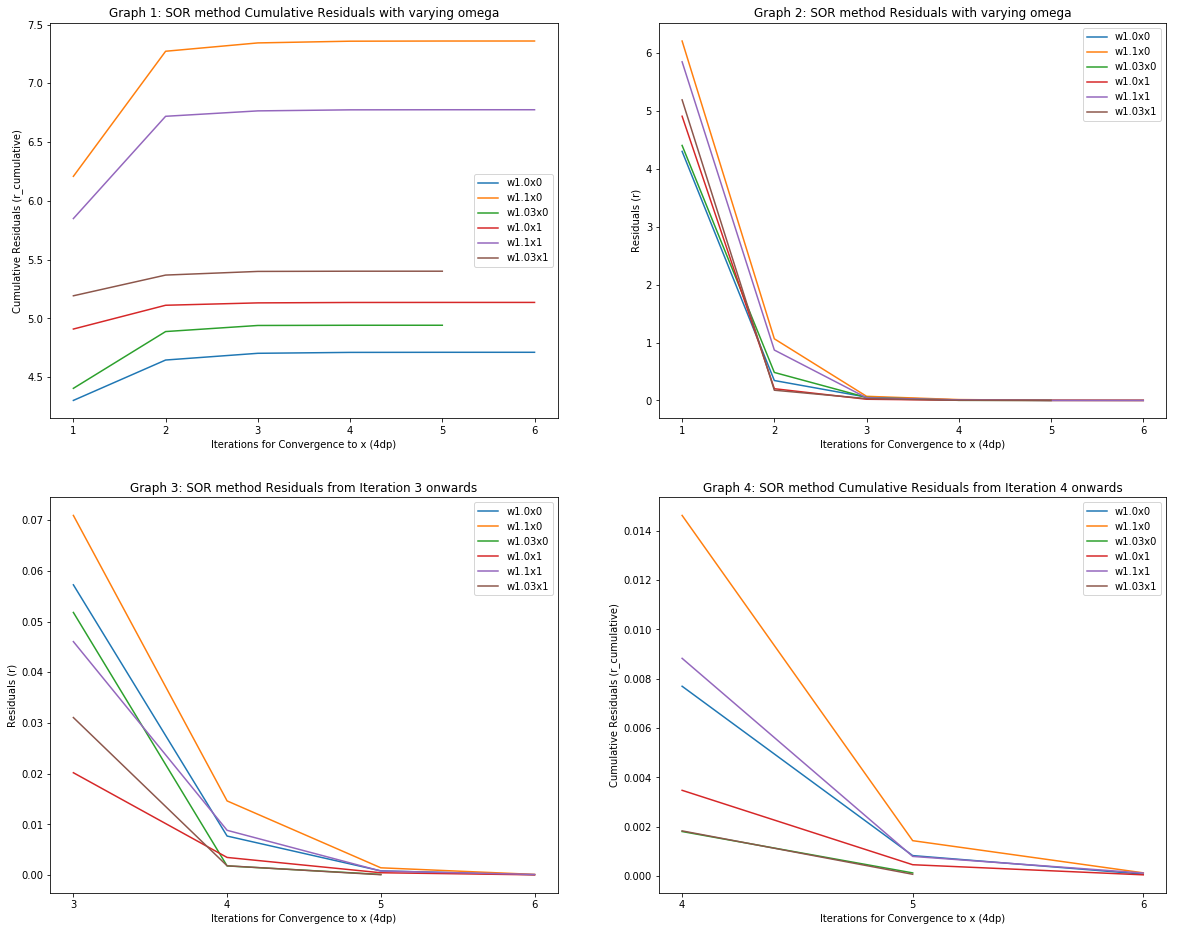

In [171]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.plot(Iterations_W0S0, np.cumsum(Residual_W0S0), label = "w1.0x0")
ax1.plot(Iterations_W1S0, np.cumsum(Residual_W1S0), label = "w1.1x0")
ax1.plot(Iterations_W2S0, np.cumsum(Residual_W2S0), label = "w1.03x0")
ax1.plot(Iterations_W0S1, np.cumsum(Residual_W0S1), label = "w1.0x1")
ax1.plot(Iterations_W1S1, np.cumsum(Residual_W1S1), label = "w1.1x1")
ax1.plot(Iterations_W2S1, np.cumsum(Residual_W2S1), label = "w1.03x1")
ax1.set(xlabel = "Iterations for Convergence to x (4dp)")
ax1.set(ylabel = "Cumulative Residuals (r_cumulative)")
ax1.set_title("Graph 1: SOR method Cumulative Residuals with varying omega")
ax1.legend()

ax2.plot(Iterations_W0S0, Residual_W0S0, label = "w1.0x0")
ax2.plot(Iterations_W1S0, Residual_W1S0, label = "w1.1x0")
ax2.plot(Iterations_W2S0, Residual_W2S0, label = "w1.03x0")
ax2.plot(Iterations_W0S1, Residual_W0S1, label = "w1.0x1")
ax2.plot(Iterations_W1S1, Residual_W1S1, label = "w1.1x1")
ax2.plot(Iterations_W2S1, Residual_W2S1, label = "w1.03x1")
ax2.set(xlabel = "Iterations for Convergence to x (4dp)")
ax2.set(ylabel = "Residuals (r)")
ax2.set_title("Graph 2: SOR method Residuals with varying omega")
ax2.legend()

ax3.plot(Iterations_W0S0[2:], Residual_W0S0[2:], label = "w1.0x0")
ax3.plot(Iterations_W1S0[2:], Residual_W1S0[2:], label = "w1.1x0")
ax3.plot(Iterations_W2S0[2:], Residual_W2S0[2:], label = "w1.03x0")
ax3.plot(Iterations_W0S1[2:], Residual_W0S1[2:], label = "w1.0x1")
ax3.plot(Iterations_W1S1[2:], Residual_W1S1[2:], label = "w1.1x1")
ax3.plot(Iterations_W2S1[2:], Residual_W2S1[2:], label = "w1.03x1")
ax3.set(xlabel = "Iterations for Convergence to x (4dp)")
ax3.set(xticks = ([3,4,5,6]))
ax3.set(ylabel = "Residuals (r)")
ax3.set_title("Graph 3: SOR method Residuals from Iteration 3 onwards")
ax3.legend()

ax4.plot(Iterations_W0S0[3:], (Residual_W0S0)[3:], label = "w1.0x0")
ax4.plot(Iterations_W1S0[3:], (Residual_W1S0)[3:], label = "w1.1x0")
ax4.plot(Iterations_W2S0[3:], (Residual_W2S0)[3:], label = "w1.03x0")
ax4.plot(Iterations_W0S1[3:], (Residual_W0S1)[3:], label = "w1.0x1")
ax4.plot(Iterations_W1S1[3:], (Residual_W1S1)[3:], label = "w1.1x1")
ax4.plot(Iterations_W2S1[3:], (Residual_W2S1)[3:], label = "w1.03x1")
ax4.set(xlabel = "Iterations for Convergence to x (4dp)")
ax4.set(xticks = ([4,5,6]))
ax4.set(ylabel = "Cumulative Residuals (r_cumulative)")
ax4.set_title("Graph 4: SOR method Cumulative Residuals from Iteration 4 onwards")
ax4.legend()

fig.set_figheight(16) 
fig.set_figwidth(20)

The above graphs show the plots of residual errors and cumulative residual errors per iteration. The graphs help to visualize the progression of the errors as our solutions iterate closer to the unique solution of x. Graph 1 shows the cumulative residuals and along with Graphs 3 and 4 highlight the optimal acceleration factor of $ \omega = 1.03 $ and its possession of the smallest error terms.

## Table 4: Comparing Iterative Methods

In [172]:
from tabulate import tabulate

table = [['SOR_x0_𝜔=1.1', Avg_Time_W1S0, Max_Time_W1S0, Min_Time_W1S0, max(Iterations_W1S0), min(Residual_W1S0)],
         ['SOR_x1_𝜔=1.1', Avg_Time_W1S1, Max_Time_W1S1, Min_Time_W1S1, max(Iterations_W1S1), min(Residual_W1S1)],
         ['SOR_x0_𝜔=1.0=GS', Avg_Time_W0S0, Max_Time_W0S0, Min_Time_W0S0, max(Iterations_W0S0), min(Residual_W0S0)],
         ['SOR_x1_𝜔=1.0=GS', Avg_Time_W0S1, Max_Time_W0S1, Min_Time_W0S1, max(Iterations_W0S1), min(Residual_W0S1)],
         ['SOR_x0_𝜔=1.03', Avg_Time_W2S0, Max_Time_W2S0, Min_Time_W2S0, max(Iterations_W2S0), min(Residual_W2S0)],
         ['SOR_x1_𝜔=1.03', Avg_Time_W2S1, Max_Time_W2S1, Min_Time_W2S1, max(Iterations_W2S1), min(Residual_W2S1)]]
         
header = ['Method', 'Average Time', 'Fastest Time', 'Slowest Time', 'Iterations', 'Residual (r)']

print(tabulate(table,headers=header))
print()
print('Note 0: Method name formula = SOR_x + initialguess + value-of-omega')
print('Note 1: Time refers to Computation Time')
print('Note 2: Iterations refers to the number of Iterations required for convergence of 𝑥̃ to x (to 4.dp)')
print('Note 3: Residual refers to the final residual error (r = b - A𝑥̃)')

Method             Average Time    Fastest Time    Slowest Time    Iterations    Residual (r)
---------------  --------------  --------------  --------------  ------------  --------------
SOR_x0_𝜔=1.1        0.000151225     0.00128675      0.000130653             6     0.0001296
SOR_x1_𝜔=1.1        0.000139076     0.00091958      0.000129938             6     0.000122392
SOR_x0_𝜔=1.0=GS     0.000140798     0.000830173     0.0001297               6     7.69731e-05
SOR_x1_𝜔=1.0=GS     0.000156107     0.00131655      0.000130653             6     4.88888e-05
SOR_x0_𝜔=1.03       0.000141191     0.000693321     0.0001297               5     0.000127245
SOR_x1_𝜔=1.03       0.000147391     0.000696898     0.000129938             5     7.13948e-05

Note 0: Method name formula = SOR_x + initialguess + value-of-omega
Note 1: Time refers to Computation Time
Note 2: Iterations refers to the number of Iterations required for convergence of 𝑥̃ to x (to 4.dp)
Note 3: Residual refers to the final resi

## Comments and observations

InitialGuess_0 $(x^{(0)}_0) = (0,0,0,0) $, InitialGuess_1 $(x^{(0)}_1) = (1,1,1,1) $

As can be seen from Table 4 the Successive Over-relaxation (SOR) method with an $ \omega = 1.1 $ is not quicker in terms of convergence than the Gauss-Seidel (GS) method (SOR with $ \omega = 1.0 $). Both mentioned methods take 6 iterations in order for our estimated solution $ \tilde{x} $ to converge to the unique solution x (to 4.dp).

However with the optimal $ \omega = 1.03 $ the table shows it takes one less iteration (5) to compute what we deem a satisfactory solution of $ \tilde{x} $. Thus showing that the SOR method can be superior in terms of **computational efficiency** to the GS method.

Additionally, I checked to see if our initial guess, $ x^{(0)} $, had a significant impact on the results ($ x^{(0)}_0 $ vs $ x^{(0)}_1 $). My results suggest the answer to this question is no. The average time taken (**speed**) at a given level of $ \omega $ is very similar. In terms of **accuracy** one could argue the $ x^{(0)}_1 $ results show marginally smaller residual error terms however I believe the size of the difference here to be insignificant.

## Table 5: Comparing all Methods

In [173]:
table = [['SOR_x0_𝜔=1.1', Avg_Time_W1S0, Max_Time_W1S0, Min_Time_W1S0, max(Iterations_W1S0), min(Residual_W1S0)],
         ['SOR_x1_𝜔=1.1', Avg_Time_W1S1, Max_Time_W1S1, Min_Time_W1S1, max(Iterations_W1S1), min(Residual_W1S1)],
         ['SOR_x0_𝜔=1.0=GS', Avg_Time_W0S0, Max_Time_W0S0, Min_Time_W0S0, max(Iterations_W0S0), min(Residual_W0S0)],
         ['SOR_x1_𝜔=1.0=GS', Avg_Time_W0S1, Max_Time_W0S1, Min_Time_W0S1, max(Iterations_W0S1), min(Residual_W0S1)],
         ['SOR_x0_𝜔=1.03', Avg_Time_W2S0, Max_Time_W2S0, Min_Time_W2S0, max(Iterations_W2S0), min(Residual_W2S0)],
         ['SOR_x1_𝜔=1.03', Avg_Time_W2S1, Max_Time_W2S1, Min_Time_W2S1, max(Iterations_W2S1), min(Residual_W2S1)],
         ['LU: Doolittle', Avg_Time_Do, Fastest_Time_Do, Slowest_Time_Do, 1, 0],
         ['LU: Crout', Avg_Time_Cr, Fastest_Time_Cr, Slowest_Time_Cr, 1, 0],
         ['LU: Cholesky', Avg_Time_Ch, Fastest_Time_Ch, Slowest_Time_Ch, 1, 0]]
         
header = ['Method', 'Average Time', 'Fastest Time', 'Slowest Time', 'Iterations', 'Residual (r)']

print(tabulate(table,headers=header))
print()
print('Note 1: Time refers to Computation Time')
print('Note 2: Iterations refers to the number of Iterations required for convergence of 𝑥̃ to x (to 4.dp)')
print('Note 3: Residual refers to the final residual error (r = b - A𝑥̃)')

Method             Average Time    Fastest Time    Slowest Time    Iterations    Residual (r)
---------------  --------------  --------------  --------------  ------------  --------------
SOR_x0_𝜔=1.1        0.000151225     0.00128675      0.000130653             6     0.0001296
SOR_x1_𝜔=1.1        0.000139076     0.00091958      0.000129938             6     0.000122392
SOR_x0_𝜔=1.0=GS     0.000140798     0.000830173     0.0001297               6     7.69731e-05
SOR_x1_𝜔=1.0=GS     0.000156107     0.00131655      0.000130653             6     4.88888e-05
SOR_x0_𝜔=1.03       0.000141191     0.000693321     0.0001297               5     0.000127245
SOR_x1_𝜔=1.03       0.000147391     0.000696898     0.000129938             5     7.13948e-05
LU: Doolittle       0.000259581     0.000196695     0.00969601              1     0
LU: Crout           0.00024352      0.000206709     0.0226922               1     0
LU: Cholesky        0.000204187     0.000184059     0.011673                1     

## Final comments and observations

As table 5 shows, the (indirect) Iterative methods are faster to arrive at a solution on average than the (direct) LU decomposition (LUD) methods. However, the Iterative methods typically only produce approximate solutions hence why the Iterative methods have residual error terms whereas the LU methods do not. Thus the LUD methods are more accurate.

A further point to note is that convergence is not always guarenteed with Iterative methods. However, the pivoting of matrix A to PA meant that our matrix became strictly diagonally dominant which in turn means that any choice of our initial guess $ x^{(0)} $ will enable the solutions generated from our Iterative methods to converge to the unique solution of x. 

To conclude, as table 5 highlights there is a trade-off between accuracy and computational efficiency when choosing between Iterative and LUD methods to solve linear systems. Iterative methods are more suited to solving systems with a higher number of equations and LUD methods a lower number of equations. For this particular assignment I believe the optimal solution method is the SOR method with $ \omega = 1.03 $ due to its balance of computational efficiency and accuracy.